#### Importing packages

In [ ]:
# importing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from math import inf
from csv import QUOTE_ALL

# For us map
import geopandas as gpd
from shapely.affinity import translate, scale
from us import states


#### Loading the datasets

In [110]:
# loading the trump data set
trumpdata = pd.read_csv(
    'US Election 2020 Tweets/hashtag_donaldtrump.csv',
    quoting=QUOTE_ALL,
    encoding='utf-8',
    on_bad_lines='skip',
    engine='python'
)

# loading the rest of the datasets
bidendata = pd.read_csv(
    'US Election 2020 Tweets/hashtag_joebiden.csv',
    on_bad_lines='skip'
)

trainingdata = pd.read_csv('training data/twitter_sentiment_training_data.csv')

initialElectionData = pd.read_csv('US Elections Dataset/1976-2020-president.csv')


/var/folders/09/83jk4_t11g1_xbmpbwwcq7sc0000gn/T/ipykernel_22522/1518209987.py:11: DtypeWarning: Columns (1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  bidendata = pd.read_csv(


## Tweet Data

### Initial Look

One way to get a nice overview of the dataset is to look at the head() as well as info(). We have utilized these to get an intial look of the data.

In [111]:
print('Biden Tweets:\n')
bidendata.info()
bidendata.head()

print('Trump Tweets Data Info:\n')
trumpdata.info()
trumpdata.head()

Biden Tweets:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059909 entries, 0 to 1059908
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   created_at            1059909 non-null  object 
 1   tweet_id              887173 non-null   object 
 2   tweet                 887173 non-null   object 
 3   likes                 887092 non-null   object 
 4   retweet_count         887073 non-null   float64
 5   source                886360 non-null   object 
 6   user_id               887067 non-null   object 
 7   user_name             887048 non-null   object 
 8   user_screen_name      786660 non-null   object 
 9   user_description      704647 non-null   object 
 10  user_join_date        776784 non-null   object 
 11  user_followers_count  776885 non-null   object 
 12  user_location         543063 non-null   object 
 13  lat                   355284 non-null   object 
 14  long               

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.3165292227484303e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,331617619.0,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529228091847e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,1185.0,Portland,45.5202471,-122.6741949,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529227471237e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.28355589206057e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.3165292523014513e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,47413798.0,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,5393.0,Washington DC,38.8949924,-77.0365581,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [112]:
# Drop unnecessary columns
columns_to_drop = ['user_name', 'user_description', 'user_join_date', 'user_location', 'source', 'collected_at', 'city', 'country', 'continent', 'state_code']
bidendata.drop(columns=[col for col in columns_to_drop if col in bidendata.columns], inplace=True)
trumpdata.drop(columns=[col for col in columns_to_drop if col in trumpdata.columns], inplace=True)


# Verify the remaining columns
print("Remaining columns in Biden data:\n", bidendata.info())
print("Remaining columns in Trump data:\n", trumpdata.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059909 entries, 0 to 1059908
Data columns (total 11 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   created_at            1059909 non-null  object 
 1   tweet_id              887173 non-null   object 
 2   tweet                 887173 non-null   object 
 3   likes                 887092 non-null   object 
 4   retweet_count         887073 non-null   float64
 5   user_id               887067 non-null   object 
 6   user_screen_name      786660 non-null   object 
 7   user_followers_count  776885 non-null   object 
 8   lat                   355284 non-null   object 
 9   long                  355284 non-null   object 
 10  state                 260191 non-null   object 
dtypes: float64(1), object(10)
memory usage: 89.0+ MB
Remaining columns in Biden data:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971087 entries, 0 to 971086
Data columns (total 11 colu

#### Total Rows and NaN Values

This not only gives us an overview of the amount of rows, but also the amount of missing NaN values. It is also essential look at the percentage of NaN values in the given column as this can help us determine whether we should drop the row or not.

In [113]:
# Total rows in the dataset
# Check the total number of rows in the dataset
biden_rows = bidendata.shape[0]
trump_rows = trumpdata.shape[0]
training_rows = trainingdata.shape[0]
print(f"Total number of rows in Biden: {biden_rows}\n")
print(f"Total number of rows in Trump: {trump_rows}\n")
print(f"Total number of rows in Training data: {training_rows}\n")


print("Total missing values in biden:\n", bidendata.isna().sum().sum(), "\n")
print("Total missing values in trump:\n", trumpdata.isna().sum().sum(), "\n")
print("Total missing values in training data:\n", trainingdata.isna().sum().sum(), "\n")

print("Missing values in the different features in biden:\n", bidendata.isna().sum())
print("Missing values in the different features in trump:\n", trumpdata.isna().sum())
print("Missing values in the different features in training data:\n", trainingdata.isna().sum())

# Calculate percentage of missing values for each column
missing_biden_percentages = (bidendata.isna().sum() / biden_rows) * 100
missing_trump_percentages = (trumpdata.isna().sum() / trump_rows) * 100
missing_training_percentages = (trainingdata.isna().sum() / trainingdata.shape[0]) * 100

# Print columns with their missing percentages
print("Percentage of missing values per column in biden:\n", missing_biden_percentages)
print("Percentage of missing values per column in trump:\n", missing_trump_percentages)
print("Percentage of missing values per column in training data:\n", missing_training_percentages)

Total number of rows in Biden: 1059909

Total number of rows in Trump: 971087

Total number of rows in Training data: 162980

Total missing values in biden:
 3629208 

Total missing values in trump:
 1701946 

Total missing values in training data:
 11 

Missing values in the different features in biden:
 created_at                   0
tweet_id                172736
tweet                   172736
likes                   172817
retweet_count           172836
user_id                 172842
user_screen_name        273249
user_followers_count    283024
lat                     704625
long                    704625
state                   799718
dtype: int64
Missing values in the different features in trump:
 created_at                   0
tweet_id                    14
tweet                       14
likes                       42
retweet_count              154
user_id                    158
user_screen_name           154
user_followers_count       170
lat                     525385
long    

In [114]:
# change sentiment to 0, 1, 2 to better align with one-hot encoding
trainingdata['category'] = trainingdata['category'].replace(1, 2)
trainingdata['category'] = trainingdata['category'].replace(0, 1)
trainingdata['category'] = trainingdata['category'].replace(-1, 0)

In [115]:
# List of all US states
us_states = initialElectionData['state'].str.upper().unique()

# Step 1: Filter rows where 'state' is a US state
bidendata = bidendata[bidendata['state'].str.upper().isin(us_states)]
trumpdata = trumpdata[trumpdata['state'].str.upper().isin(us_states)]

# Step 2: Drop rows with NaN values in 'state'
bidendata = bidendata.dropna(subset=['state'])
trumpdata = trumpdata.dropna(subset=['state'])

# Calculate the percentage of tweets for each state
state_percentages = bidendata['state'].value_counts(normalize=True) * 100
state_percentages = trumpdata['state'].value_counts(normalize=True) * 100

# Check the final dataset shape and missing values
print("\nBiden dataset shape:", bidendata.shape)
print("\nTrump dataset shape:", trumpdata.shape)

print("Missing values in the cleaned Biden dataset:\n", bidendata.isna().sum())
print("Missing values in the cleaned Trump dataset:\n", trumpdata.isna().sum())


Biden dataset shape: (153095, 11)

Trump dataset shape: (178378, 11)
Missing values in the cleaned Biden dataset:
 created_at              0
tweet_id                0
tweet                   0
likes                   0
retweet_count           0
user_id                 0
user_screen_name        0
user_followers_count    0
lat                     0
long                    0
state                   0
dtype: int64
Missing values in the cleaned Trump dataset:
 created_at              0
tweet_id                0
tweet                   0
likes                   0
retweet_count           0
user_id                 0
user_screen_name        0
user_followers_count    0
lat                     0
long                    0
state                   0
dtype: int64


As seen above, some of the rows have very high percentages of missing values. We have decided to drop the columns with a too high percentage of missing rows, while filling in the missing values for the rest. Specifically for 'State' we have decided to keep it as it is essential to our analysis.

In [116]:
# Drop rows with missing critical identifiers
bidendata.dropna(subset=['tweet_id', 'tweet', 'user_id', 'user_screen_name', 'long', 'lat'], inplace=True)
trumpdata.dropna(subset=['tweet_id', 'tweet', 'user_id', 'user_screen_name', 'long', 'lat'], inplace=True)
trainingdata = trainingdata.dropna()

# Filling missing values for critical columns such as the amount of likes and retweets
bidendata['likes'] = pd.to_numeric(bidendata['likes'], errors='coerce').fillna(0).astype(int)
trumpdata['likes'] = pd.to_numeric(trumpdata['likes'], errors='coerce').fillna(0).astype(int)

bidendata['retweet_count'] = pd.to_numeric(bidendata['retweet_count'], errors='coerce').fillna(0).astype(int)
trumpdata['retweet_count'] = pd.to_numeric(trumpdata['retweet_count'], errors='coerce').fillna(0).astype(int)

# Handle 'user_followers_count' by filling missing values with 0
bidendata['user_followers_count'] = pd.to_numeric(bidendata['user_followers_count'], errors='coerce').fillna(0).astype(int)
trumpdata['user_followers_count'] = pd.to_numeric(trumpdata['user_followers_count'], errors='coerce').fillna(0).astype(int)

# Removing non-string rows
bidendata = bidendata[bidendata['tweet'].apply(str).str.isnumeric() == False]
trumpdata = trumpdata[trumpdata['tweet'].apply(str).str.isnumeric() == False]
trainingdata = trainingdata[trainingdata['clean_text'].apply(str).str.isnumeric() == False]

# Verifying the amount of NaN values
print("Total missing values in Biden:\n", bidendata.isna().sum().sum(), "\n")
print("Missing values in the different features (biden):\n", bidendata.isna().sum())

print("\nTotal missing values Trump:\n", trumpdata.isna().sum().sum(), "\n")
print("Missing values in the different features (trump):\n", trumpdata.isna().sum())

print("\nTotal missing values Training data:\n", trainingdata.isna().sum().sum(), "\n")
print("Missing values in the different features (training data):\n", trainingdata.isna().sum())

# Final dataset shape
print(f"\nCleaned Biden dataset shape: {bidendata.shape}")
print(f"Total number of rows in Biden dataset: {biden_rows}")

print(f"\nCleaned Trump dataset shape: {trumpdata.shape}")
print(f"Total number of rows in Trump dataset: {trump_rows}\n")

print(f"\nCleaned Training dataset shape: {trainingdata.shape}")
print(f"Total number of rows in Training dataset: {training_rows}\n")


Total missing values in Biden:
 0 

Missing values in the different features (biden):
 created_at              0
tweet_id                0
tweet                   0
likes                   0
retweet_count           0
user_id                 0
user_screen_name        0
user_followers_count    0
lat                     0
long                    0
state                   0
dtype: int64

Total missing values Trump:
 0 

Missing values in the different features (trump):
 created_at              0
tweet_id                0
tweet                   0
likes                   0
retweet_count           0
user_id                 0
user_screen_name        0
user_followers_count    0
lat                     0
long                    0
state                   0
dtype: int64

Total missing values Training data:
 0 

Missing values in the different features (training data):
 clean_text    0
category      0
dtype: int64

Cleaned Biden dataset shape: (153095, 11)
Total number of rows in Biden dataset: 10

In [117]:
# Verify the remaining columns
print("\nRemaining columns after dropping unnecessary ones:")
bidendata.info()
trumpdata.info()


Remaining columns after dropping unnecessary ones:
<class 'pandas.core.frame.DataFrame'>
Index: 153095 entries, 0 to 1059895
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   created_at            153095 non-null  object
 1   tweet_id              153095 non-null  object
 2   tweet                 153095 non-null  object
 3   likes                 153095 non-null  int64 
 4   retweet_count         153095 non-null  int64 
 5   user_id               153095 non-null  object
 6   user_screen_name      153095 non-null  object
 7   user_followers_count  153095 non-null  int64 
 8   lat                   153095 non-null  object
 9   long                  153095 non-null  object
 10  state                 153095 non-null  object
dtypes: int64(3), object(8)
memory usage: 14.0+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 178378 entries, 0 to 971073
Data columns (total 11 columns):
 #   Column          

## Cleaning election results data

#### Jury data

In [121]:
# drop data not from 2020
electiondata = initialElectionData[initialElectionData['year'].astype(int) == 2020]

# drop data not consisting regarding other than democrat or republican
electiondata = electiondata[electiondata['party_detailed'].isin(['DEMOCRAT', 'REPUBLICAN'])]

# check the values
electiondata['party_detailed'].unique()

array(['DEMOCRAT', 'REPUBLICAN'], dtype=object)

#### Alex data

##### Dataframe for elections 1976-2020

In [122]:
# Filter the to only include the 1976-2020 election results
election_results_2000_to_2020 = initialElectionData[initialElectionData['year'].between(2000, 2020)]

# Drop the unnecessary columns
election_results_2000_to_2020.drop(columns=['notes', 'party_detailed', 'version', 'office' , 'candidate', 'writein'], inplace=True)


election_results_2000_to_2020.info()
election_results_2000_to_2020.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2245 entries, 2042 to 4286
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              2245 non-null   int64 
 1   state             2245 non-null   object
 2   state_po          2245 non-null   object
 3   state_fips        2245 non-null   int64 
 4   state_cen         2245 non-null   int64 
 5   state_ic          2245 non-null   int64 
 6   candidatevotes    2245 non-null   int64 
 7   totalvotes        2245 non-null   int64 
 8   party_simplified  2245 non-null   object
dtypes: int64(6), object(3)
memory usage: 175.4+ KB


/var/folders/09/83jk4_t11g1_xbmpbwwcq7sc0000gn/T/ipykernel_22522/3661201392.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_results_2000_to_2020.drop(columns=['notes', 'party_detailed', 'version', 'office' , 'candidate', 'writein'], inplace=True)


,year,state,state_po,state_fips,state_cen,state_ic,candidatevotes,totalvotes,party_simplified
2042,2000,ALABAMA,AL,1,63,41,941173,1666272,REPUBLICAN
2043,2000,ALABAMA,AL,1,63,41,692611,1666272,DEMOCRAT
2044,2000,ALABAMA,AL,1,63,41,25896,1666272,OTHER
2045,2000,ALABAMA,AL,1,63,41,5893,1666272,LIBERTARIAN
2046,2000,ALABAMA,AL,1,63,41,699,1666272,OTHER


##### Dataframe for 2020 election and tweets

In [123]:
# Filter the to only include the 2020 election results
election_results2020 = initialElectionData[initialElectionData['year'] == 2020]

# Filter to only include Democratic and Republican party results
election_results2020 = election_results2020[
    (election_results2020['party_simplified'] == 'DEMOCRAT') | (election_results2020['party_simplified'] == 'REPUBLICAN')
]

# Drop the unnecessary columns
election_results2020.drop(columns=['notes', 'party_detailed', 'version', 'office','year', 'writein'], inplace=True)

# Group by state and determine the winning party based on the maximum candidate votes
election_results2020 = election_results2020.loc[
    election_results2020.groupby('state')['candidatevotes'].idxmax()
]

# Rename column 'party_simplified' to 'winning_party'
election_results2020 = election_results2020.rename(columns={'party_simplified': 'winning_party'})


# Verify the remaining columns
election_results2020.info()
election_results2020.head()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 3741 to 4281
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   state           51 non-null     object
 1   state_po        51 non-null     object
 2   state_fips      51 non-null     int64 
 3   state_cen       51 non-null     int64 
 4   state_ic        51 non-null     int64 
 5   candidate       51 non-null     object
 6   candidatevotes  51 non-null     int64 
 7   totalvotes      51 non-null     int64 
 8   winning_party   51 non-null     object
dtypes: int64(5), object(4)
memory usage: 4.0+ KB


,state,state_po,state_fips,state_cen,state_ic,candidate,candidatevotes,totalvotes,winning_party
3741,ALABAMA,AL,1,63,41,"TRUMP, DONALD J.",1441170,2323282,REPUBLICAN
3745,ALASKA,AK,2,94,81,"TRUMP, DONALD J.",189951,359530,REPUBLICAN
3752,ARIZONA,AZ,4,86,61,"BIDEN, JOSEPH R. JR",1672143,3387326,DEMOCRAT
3771,ARKANSAS,AR,5,71,42,"TRUMP, DONALD J.",760647,1219069,REPUBLICAN
3773,CALIFORNIA,CA,6,93,71,"BIDEN, JOSEPH R. JR",11110250,17500881,DEMOCRAT


# Data Visualization

#### Election results 1972-2020

/var/folders/09/83jk4_t11g1_xbmpbwwcq7sc0000gn/T/ipykernel_22522/4028626109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_results_2000_to_2020['percentage'] = (election_results_2000_to_2020['candidatevotes'] / election_results_2000_to_2020['totalvotes']) * 100


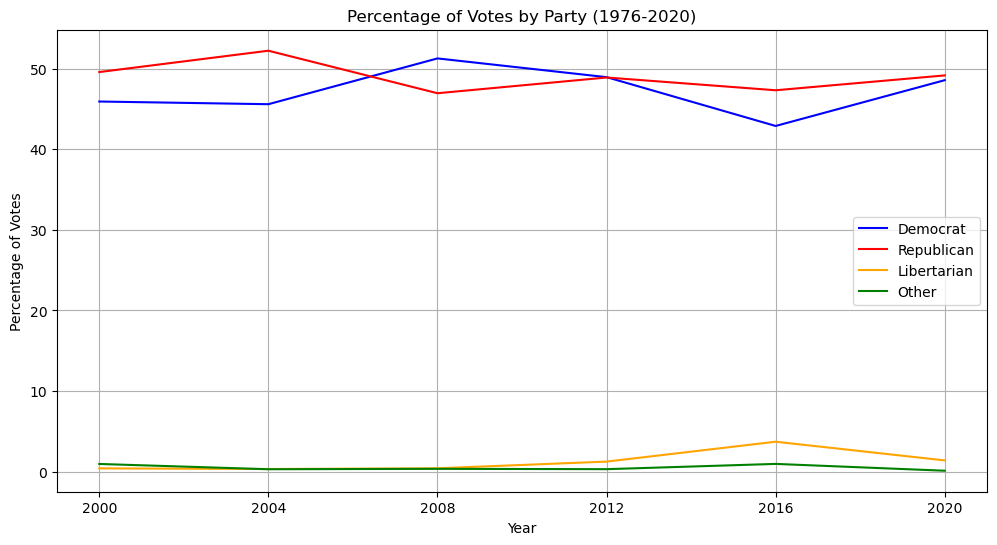

In [124]:
# Calculate the percentage of votes for each party in each state
election_results_2000_to_2020['percentage'] = (election_results_2000_to_2020['candidatevotes'] / election_results_2000_to_2020['totalvotes']) * 100

# Filter data for each party
democrat_data = election_results_2000_to_2020[election_results_2000_to_2020['party_simplified'] == 'DEMOCRAT']
republican_data = election_results_2000_to_2020[election_results_2000_to_2020['party_simplified'] == 'REPUBLICAN']
libertarian_data = election_results_2000_to_2020[election_results_2000_to_2020['party_simplified'] == 'LIBERTARIAN']
other_data = election_results_2000_to_2020[election_results_2000_to_2020['party_simplified'] == 'OTHER']

# Group by year and calculate the mean percentage for each party
democrat_percentage = democrat_data.groupby('year')['percentage'].mean()
republican_percentage = republican_data.groupby('year')['percentage'].mean()
libertarian_percentage = libertarian_data.groupby('year')['percentage'].mean()
other_percentage = other_data.groupby('year')['percentage'].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(democrat_percentage.index, democrat_percentage.values, label='Democrat', color='blue')
plt.plot(republican_percentage.index, republican_percentage.values, label='Republican', color='red')
plt.plot(libertarian_percentage.index, libertarian_percentage.values, label='Libertarian', color='orange')
plt.plot(other_percentage.index, other_percentage.values, label='Other', color='green')

plt.title('Percentage of Votes by Party (1976-2020)')
plt.xlabel('Year')
plt.xticks(democrat_percentage.index, democrat_percentage.index.astype(int))
plt.ylabel('Percentage of Votes')
plt.legend()
plt.grid(True)
plt.show()

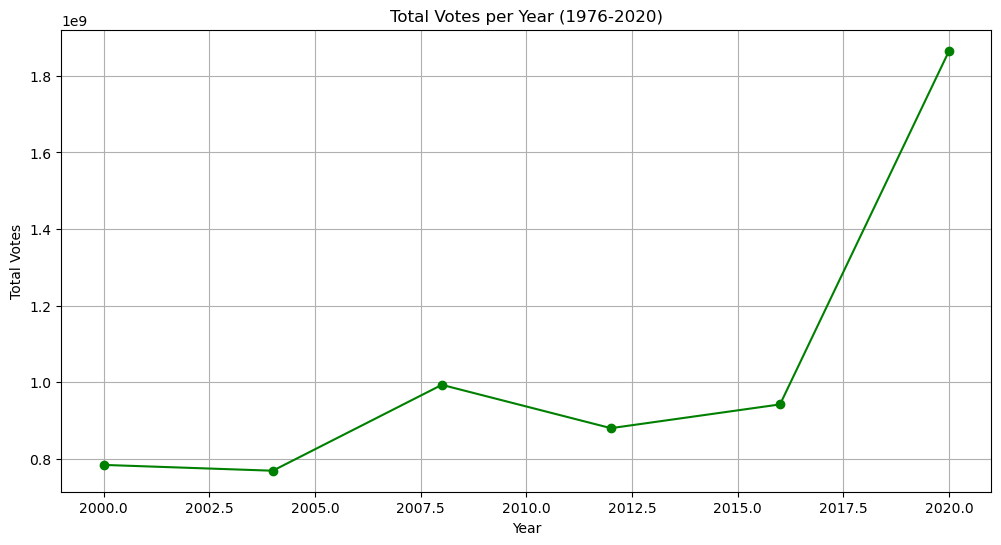

In [125]:
# Calculate total votes per year
total_votes_per_year = election_results_2000_to_2020.groupby('year')['totalvotes'].sum()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(total_votes_per_year.index, total_votes_per_year.values, marker='o', linestyle='-', color='g')
plt.title('Total Votes per Year (1976-2020)')
plt.xlabel('Year')
plt.ylabel('Total Votes')
plt.grid(True)
plt.show()

#### Election results 2020

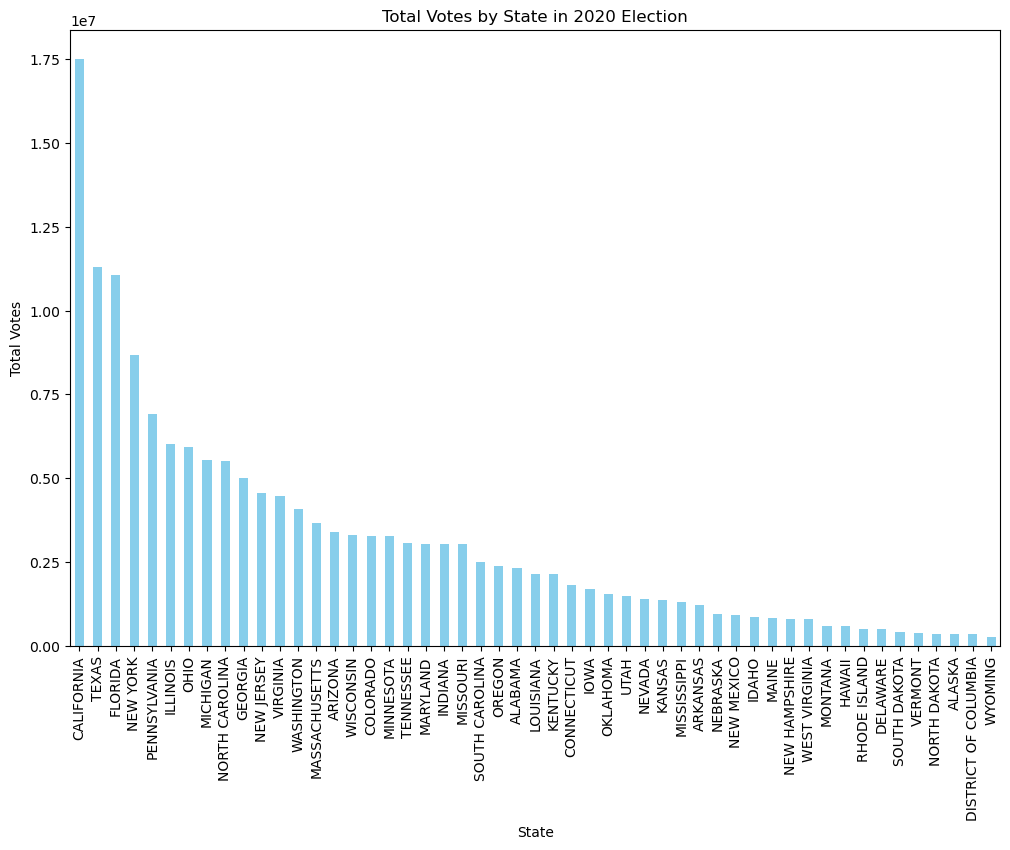

In [126]:
# Calculate total votes by state
total_votes_by_state = election_results2020.groupby('state')['totalvotes'].sum().sort_values(ascending=False)

# Plot the total votes by state in a bar chart
plt.figure(figsize=(12, 8))
total_votes_by_state.plot(kind='bar', color='skyblue')
plt.title('Total Votes by State in 2020 Election')
plt.xlabel('State')
plt.ylabel('Total Votes')
plt.xticks(rotation=90)
plt.show()

#### Tweets data

In [127]:
bidendata['likes'] = pd.to_numeric(bidendata['likes'], errors='coerce')
trumpdata['likes'] = pd.to_numeric(trumpdata['likes'], errors='coerce')

# Get top 10 most liked tweets for Biden dataset
top_liked_biden = bidendata.nlargest(10, 'likes')[['tweet', 'likes']]

# Get top 10 most liked tweets for Trump dataset
top_liked_trump = trumpdata.nlargest(10, 'likes')[['tweet', 'likes']]

# Display the results
print("Top 10 Most Liked Tweets - Biden Hashtag:")
print(top_liked_biden)

print("\nTop 10 Most Liked Tweets - Trump Hashtag:")
print(top_liked_trump)

Top 10 Most Liked Tweets - Biden Hashtag:
                                                    tweet   likes
20435   Tonight a woman in the audience of Trump's tow...  165702
611955  America Assembled!🇺🇸🎉\n\n@JoeBiden @KamalaHarr...   74528
196718  Are you there, God? It's me, Bette. I'm so sca...   59403
996551  Wonderful speeches tonight by President and Vi...   59345
281655  Are you there, God? It's me again, Bette. We'r...   45540
16737   OMG!  #JoeBiden speaks like a human being!  An...   43399
145822  Whatever you do, DON’T BELIEVE THE POLLS.  Vot...   22654
398265  The big fight TODAY!!!!! @realDonaldTrump vs #...   22641
648234                #Biden wins https://t.co/MUi0oXgs73   22004
538920  My best vote-counter source in #PA now predict...   20967

Top 10 Most Liked Tweets - Trump Hashtag:
                                                    tweet  likes
786671  America Assembled!🇺🇸🎉\n\n@JoeBiden @KamalaHarr...  74084
245120  The White House still has not released a healt...  

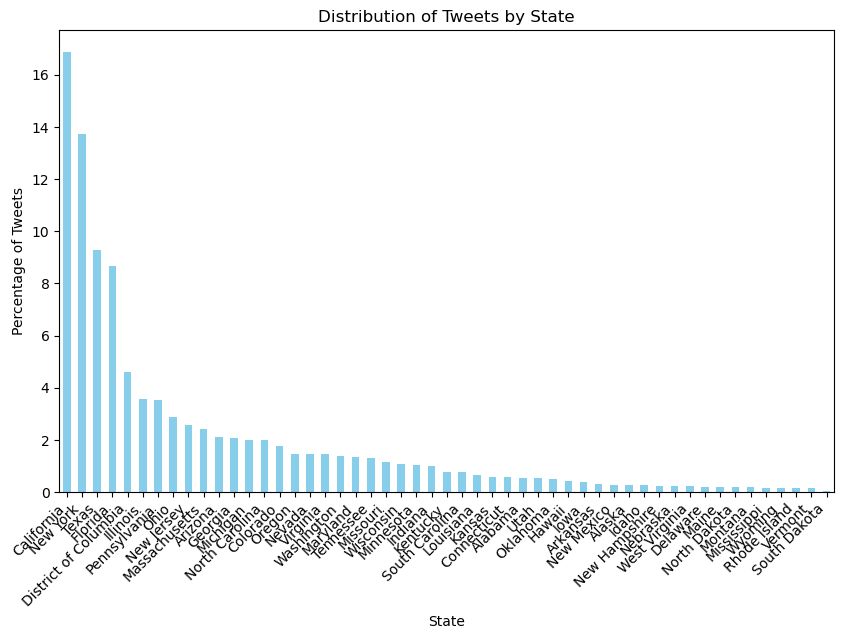

In [128]:
# Calculate the distribution of tweets by state
state_distribution = bidendata['state'].value_counts(normalize=True) * 100 # Maybe get citizens of state and divide so we get an actual normalization?

# Bar chart
plt.figure(figsize=(10, 6))
state_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Tweets by State')
plt.xlabel('State')
plt.ylabel('Percentage of Tweets')
plt.xticks(rotation=45, ha='right')
plt.show()


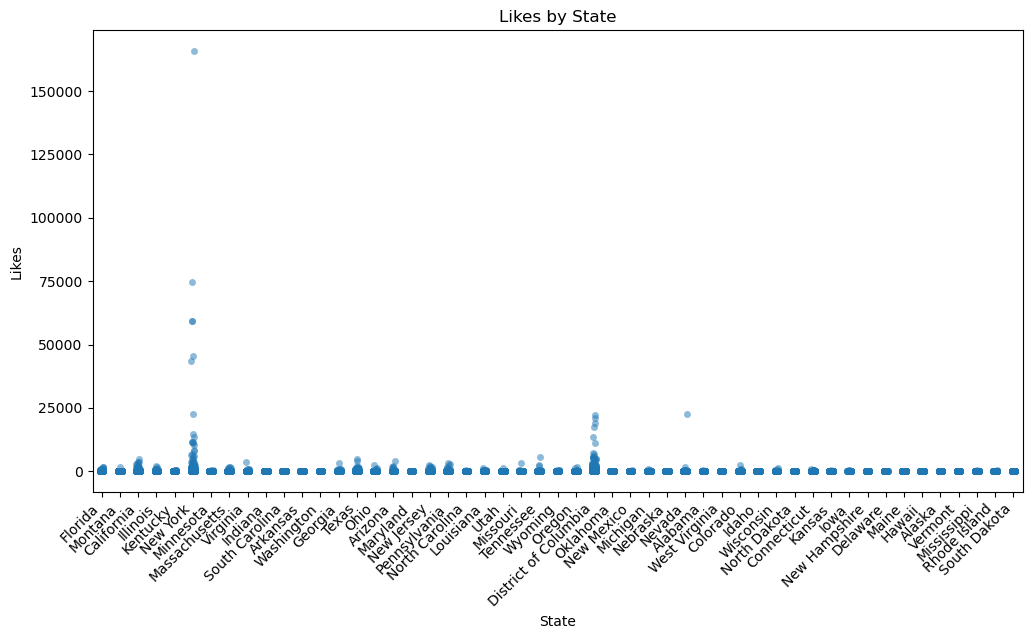

In [129]:
plt.figure(figsize=(12, 6))
sns.stripplot(x='state', y='likes', data=bidendata, jitter=True, alpha=0.5)
plt.title('Likes by State')
plt.xlabel('State')
plt.ylabel('Likes')
plt.xticks(rotation=45, ha='right')
plt.show()


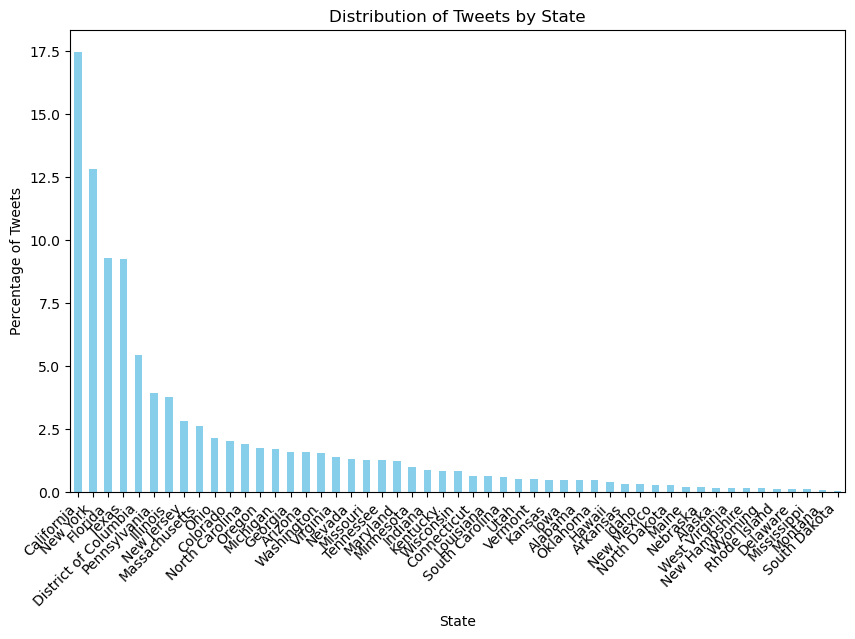

In [130]:
# Calculate the distribution of tweets by state
state_distribution = trumpdata['state'].value_counts(normalize=True) * 100

# Bar chart
plt.figure(figsize=(10, 6))
state_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Tweets by State')
plt.xlabel('State')
plt.ylabel('Percentage of Tweets')
plt.xticks(rotation=45, ha='right')
plt.show()


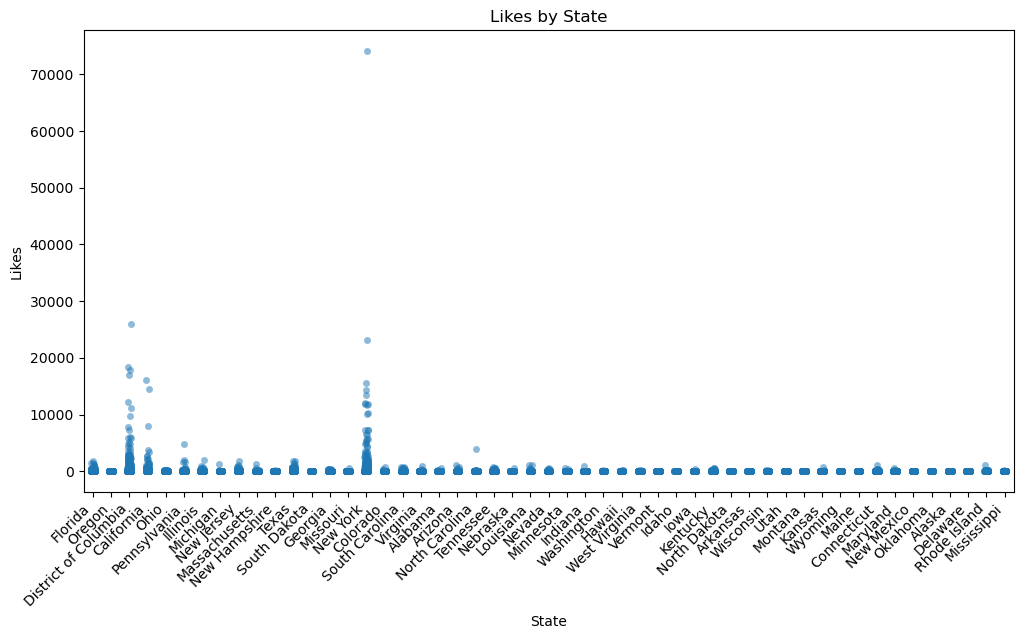

In [131]:
plt.figure(figsize=(12, 6))
sns.stripplot(x='state', y='likes', data=trumpdata, jitter=True, alpha=0.5)
plt.title('Likes by State')
plt.xlabel('State')
plt.ylabel('Likes')
plt.xticks(rotation=45, ha='right')
plt.show()


As seen above, the data for 'State' is quite similar for the two datasets.

In [132]:
# training data categories should have the same amount of tweets
def sample_min_group_size(group):
    return group.sample(trainingdata['category'].value_counts().min()).reset_index(drop=True)

trainingdata = trainingdata.groupby('category').apply(sample_min_group_size)

/var/folders/09/83jk4_t11g1_xbmpbwwcq7sc0000gn/T/ipykernel_22522/1185353498.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trainingdata = trainingdata.groupby('category').apply(sample_min_group_size)


In [133]:
# how many are left
print('Biden:', len(bidendata))
print('Trump:', len(trumpdata))

Biden: 153095
Trump: 178378


In [134]:
# preprocessing the training data
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

bidendata['tweet'] = bidendata['tweet'].apply(preprocess)
trumpdata['tweet'] = trumpdata['tweet'].apply(preprocess)
trainingdata['clean_text'] = trainingdata['clean_text'].apply(preprocess)

#### Map of US 2020 election results

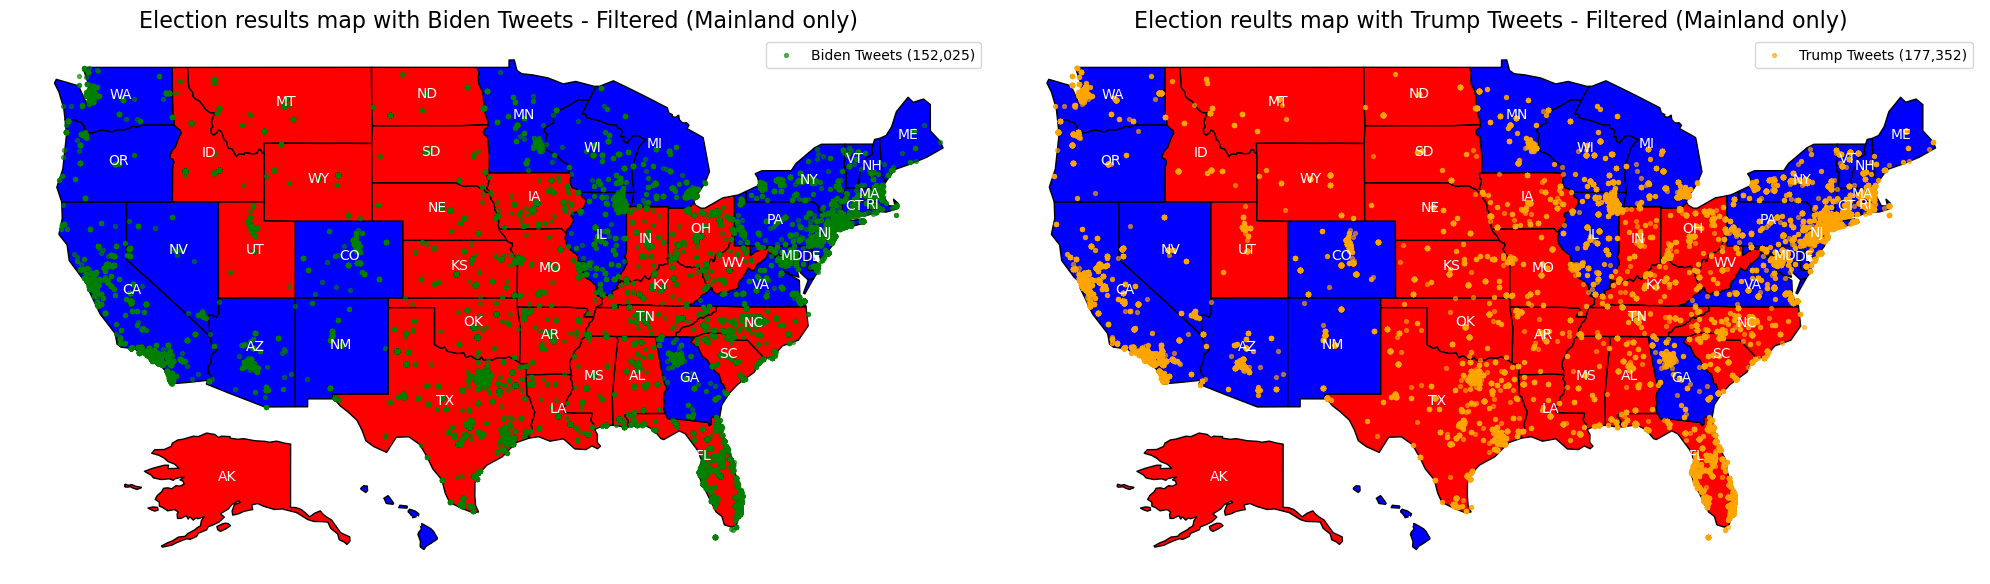

In [135]:
# Load the shapefile for U.S. states
us_states = gpd.read_file('map data/ne_110m_admin_1_states_provinces.shp')

# Filter for U.S. states only
us_states = us_states[us_states['admin'] == 'United States of America']

# Map state names to postal abbreviations
state_abbr = {state.name: state.abbr for state in states.STATES}
us_states['state_po'] = us_states['name'].map(state_abbr)

# Reposition Alaska and Hawaii
def transform_state(state, xoff, yoff, scale_factor):
    state = state.copy()
    state.geometry = state.geometry.apply(lambda geom: scale(geom, xfact=scale_factor, yfact=scale_factor, origin=(0, 0)))
    state.geometry = state.geometry.apply(lambda geom: translate(geom, xoff=xoff, yoff=yoff))
    return state

alaska = us_states[us_states['state_po'] == 'AK']
alaska = transform_state(alaska, xoff=-60, yoff=5, scale_factor=0.35)

hawaii = us_states[us_states['state_po'] == 'HI']
hawaii = transform_state(hawaii, xoff=55, yoff=5, scale_factor=1.0)

# Remove original Alaska and Hawaii and add repositioned ones
us_states = us_states[~us_states['state_po'].isin(['AK', 'HI'])]
us_states = pd.concat([us_states, alaska, hawaii])

# Merge map data with election results
map_data = us_states.merge(election_results2020, on='state_po', how='left')

# Assign colors to states based on the winning party
party_colors = {'DEMOCRAT': 'blue', 'REPUBLICAN': 'red'}
map_data['color'] = map_data['winning_party'].map(party_colors).fillna('grey')

# Define a bounding box for the contiguous U.S. states
MAINLAND_BOUNDS = {
    'lat_min': 24.396308,  # Southern tip of Florida
    'lat_max': 49.384358,  # Northern border with Canada
    'lon_min': -125.0,     # Western edge (California/Oregon)
    'lon_max': -66.93457   # Eastern edge (Maine)
}

def filter_mainland_tweets(df):
    """Remove tweets outside the contiguous U.S. mainland bounding box."""
    # Ensure latitude and longitude are numeric
    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['long'] = pd.to_numeric(df['long'], errors='coerce')
    
    # Filter tweets within the mainland U.S. bounding box
    return df[
        (df['lat'] >= MAINLAND_BOUNDS['lat_min']) & (df['lat'] <= MAINLAND_BOUNDS['lat_max']) &
        (df['long'] >= MAINLAND_BOUNDS['lon_min']) & (df['long'] <= MAINLAND_BOUNDS['lon_max'])
    ].dropna(subset=['lat', 'long'])

# Filter tweets to remove those outside the contiguous U.S.
bidendata_filtered = filter_mainland_tweets(bidendata)
trumpdata_filtered = filter_mainland_tweets(trumpdata)

# Create GeoDataFrames for filtered tweet data
biden_tweets = gpd.GeoDataFrame(
    bidendata_filtered, geometry=gpd.points_from_xy(bidendata_filtered['long'], bidendata_filtered['lat']), crs="EPSG:4326"
)
trump_tweets = gpd.GeoDataFrame(
    trumpdata_filtered, geometry=gpd.points_from_xy(trumpdata_filtered['long'], trumpdata_filtered['lat']), crs="EPSG:4326"
)

# Plot maps side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Biden tweets map
map_data.plot(ax=axes[0], color=map_data['color'], edgecolor='black')
biden_tweets.plot(ax=axes[0], color='green', markersize=8, alpha=0.6, label='Biden Tweets (152,025)')

# Add state postal abbreviations to Biden map
for idx, row in map_data.iterrows():
    if pd.notna(row['state_po']):
        axes[0].annotate(
            row['state_po'],
            xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
            ha='center',
            fontsize=10,
            color='white'
        )

axes[0].set_title("Election results map with Biden Tweets - Filtered (Mainland only)", fontsize=16)
axes[0].axis('off')
axes[0].legend()

# Trump tweets map
map_data.plot(ax=axes[1], color=map_data['color'], edgecolor='black')
trump_tweets.plot(ax=axes[1], color='orange', markersize=8, alpha=0.6, label='Trump Tweets (177,352)')

# Add state postal abbreviations to Trump map
for idx, row in map_data.iterrows():
    if pd.notna(row['state_po']):
        axes[1].annotate(
            row['state_po'],
            xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
            ha='center',
            fontsize=10,
            color='white'
        )

axes[1].set_title("Election reults map with Trump Tweets - Filtered (Mainland only)", fontsize=16)
axes[1].axis('off')
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

# Training the classifier

In [136]:
# Parameters
max_words = 10000 
max_len = 100   

# Tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(trainingdata['clean_text'])

# Tokenizing and padding sequences
sequences = tokenizer.texts_to_sequences(trainingdata['clean_text'])
X = pad_sequences(sequences, maxlen=max_len, padding='post')

# One-hot encode labels for multi-class classification
y = to_categorical(trainingdata['category'], num_classes=3) # 3 classes: 0, 1, 2


In [137]:
# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (85221, 100), y_train shape: (85221, 3)
X_test shape: (21306, 100), y_test shape: (21306, 3)


In [138]:
# Defining the model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(3, activation='softmax')  # Output layer for 3 classes (0, 1, 2: negative, neutral, positive)
    
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



/opt/anaconda3/envs/data-mining-course/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [139]:
best_loss = inf
best_batch_size = None
best_model_weights = None

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,          
    restore_best_weights=True 
)

batch_sizes = [16, 32, 64, 128]

# Training the model while keeping track of the best batch size and epoch
for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")
    
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    
    max_val_accuracy = max(history.history['val_accuracy'])
    
    # Save the weights for the best model
    if max_val_accuracy < best_loss:
        best_loss = max_val_accuracy
        best_batch_size = batch_size
        best_model_weights = model.get_weights()


model.set_weights(best_model_weights)
print(f"\nBest model found with batch size: {best_batch_size} and validation accuracy: {best_loss}")


Training with batch size: 16
Epoch 1/50
4261/4261 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.6827 - loss: 0.6952 - val_accuracy: 0.9125 - val_loss: 0.2740
Epoch 2/50
4261/4261 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9355 - loss: 0.2146 - val_accuracy: 0.9170 - val_loss: 0.2645
Epoch 3/50
4261/4261 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9650 - loss: 0.1139 - val_accuracy: 0.9145 - val_loss: 0.3053
Epoch 4/50
4261/4261 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9788 - loss: 0.0695 - val_accuracy: 0.9101 - val_loss: 0.4205
Epoch 5/50
4261/4261 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9846 - loss: 0.0488 - val_accuracy: 0.9125 - val_loss: 0.4525

Training with batch size: 32
Epoch 1/50
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9699 - loss: 0.1020 - val_accuracy: 0.9187 - val_loss: 0.3041
Epoch 2/50
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9838 - loss: 0.0525 - val_accuracy: 0.9136 - val_loss: 0.3769
Epoch 3/50
2131/2131 ━━

In [140]:
# processing the biden and trump text
def preprocess_tweets(texts, max_len=100):
    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(texts)
    # Pad sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences

preprocessed_tweets_trump = preprocess_tweets(trumpdata['tweet'])
preprocessed_tweets_biden = preprocess_tweets(bidendata['tweet'])

In [141]:
# Predict probabilities
trump_predictions = model.predict(preprocessed_tweets_trump)
biden_predictions = model.predict(preprocessed_tweets_biden)

# Convert probabilities to class labels
predicted_classes_trump = trump_predictions.argmax(axis=-1)
predicted_classes_biden = biden_predictions.argmax(axis=-1)

# Map numeric classes to sentiment labels
class_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
predicted_labels_trump = [class_mapping[label] for label in predicted_classes_trump]
predicted_labels_biden = [class_mapping[label] for label in predicted_classes_biden]

trumpdata['predicted_label'] = predicted_labels_trump
trumpdata['predicted_sentiment'] = predicted_classes_trump

bidendata['predicted_label'] = predicted_labels_biden
bidendata['predicted_sentiment'] = predicted_classes_biden

print(trumpdata[['tweet', 'predicted_sentiment']].head())

5575/5575 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
4785/4785 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
                                               tweet  predicted_sentiment
0  elecciones2020  en florida joebiden dice que d...                    1
2  trump as a student i used to hear for years fo...                    2
4  you get a tie and you get a tie trump ‘s rally...                    1
5  clady62 her 15 minutes were over long time ago...                    0
7  deeviousdenise realdonaldtrump nypost there wo...                    2


In [142]:
# sanity check

# Make predictions
to_test = ["I am very happy", "I am slightly happy", "I am neither happy nor sad", 
           "I am neutral", "I am slightly sad", "I am very sad", "I love our leader", "I am indifferent about our leader", "I hate our leader"]
sequences = tokenizer.texts_to_sequences(to_test)
X_test = pad_sequences(sequences, maxlen=max_len, padding='post')
predictions = model.predict(X_test)

# Print the predictions
for i, prediction in enumerate(predictions):
    print(f"Text: {to_test[i]}")
    predicted_sentiment = np.argmax(prediction)
    sentiment_label = class_mapping[predicted_sentiment]
    print(f"Predicted sentiment: {sentiment_label}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Text: I am very happy
Predicted sentiment: Positive

Text: I am slightly happy
Predicted sentiment: Positive

Text: I am neither happy nor sad
Predicted sentiment: Negative

Text: I am neutral
Predicted sentiment: Neutral

Text: I am slightly sad
Predicted sentiment: Negative

Text: I am very sad
Predicted sentiment: Negative

Text: I love our leader
Predicted sentiment: Positive

Text: I am indifferent about our leader
Predicted sentiment: Neutral

Text: I hate our leader
Predicted sentiment: Negative



#### Random Forest Classifier

In [143]:
# Step 1: Add a column for candidate
trumpdata['tweet_hashtag'] = 'Trump'
bidendata['tweet_hashtag'] = 'Biden'

In [144]:
# Step 2: Combine the datasets
combined_data = pd.concat([trumpdata, bidendata], ignore_index=True)

combined_data.info()
combined_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331473 entries, 0 to 331472
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            331473 non-null  object 
 1   tweet_id              331473 non-null  object 
 2   tweet                 331473 non-null  object 
 3   likes                 331473 non-null  int64  
 4   retweet_count         331473 non-null  int64  
 5   user_id               331473 non-null  object 
 6   user_screen_name      331473 non-null  object 
 7   user_followers_count  331473 non-null  int64  
 8   lat                   331473 non-null  float64
 9   long                  331473 non-null  float64
 10  state                 331473 non-null  object 
 11  predicted_label       331473 non-null  object 
 12  predicted_sentiment   331473 non-null  int64  
 13  tweet_hashtag         331473 non-null  object 
dtypes: float64(2), int64(4), object(8)
memory usage: 35.

,created_at,tweet_id,tweet,likes,retweet_count,user_id,user_screen_name,user_followers_count,lat,long,state,predicted_label,predicted_sentiment,tweet_hashtag
0,2020-10-15 00:00:01,1.316529221557252e+18,elecciones2020 en florida joebiden dice que d...,0,0,360666534.0,elsollatinonews,1860,25.774270,-80.193660,Florida,Neutral,1,Trump
1,2020-10-15 00:00:02,1.316529228091847e+18,trump as a student i used to hear for years fo...,2,1,8436472.0,snarke,1185,45.520247,-122.674195,Oregon,Positive,2,Trump
2,2020-10-15 00:00:08,1.3165292523014513e+18,you get a tie and you get a tie trump ‘s rally...,4,3,47413798.0,Ranaabtar,5393,38.894992,-77.036558,District of Columbia,Neutral,1,Trump
3,2020-10-15 00:00:17,1.316529291052675e+18,clady62 her 15 minutes were over long time ago...,2,0,1138416104.0,FarrisFlagg,2363,33.782519,-117.228648,California,Negative,0,Trump
4,2020-10-15 00:00:18,1.3165292934979625e+18,deeviousdenise realdonaldtrump nypost there wo...,0,0,9.007610716314296e+17,sm_gulledge,766,40.225357,-82.688140,Ohio,Positive,2,Trump


In [145]:
# Step 1: Align sentiment predictions with combined_data
trump_predictions_aligned = predicted_labels_trump[:len(trumpdata)]
biden_predictions_aligned = predicted_labels_biden[:len(bidendata)]

# Combine the predictions
aligned_predictions = []
for idx, row in combined_data.iterrows():
    if row['tweet_hashtag'] == 'Trump':
        aligned_predictions.append(trump_predictions_aligned[idx])
    elif row['tweet_hashtag'] == 'Biden':
        aligned_predictions.append(biden_predictions_aligned[idx - len(trumpdata)])  # Adjust index for Biden

# Step 2: Add sentiment column
combined_data['sentiment'] = aligned_predictions

# Step 3: Map sentiment and hashtag to numeric scores (include Neutral)
sentiment_mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}
hashtag_mapping = {"Trump": 0, "Biden": 1}

combined_data['sentiment_score'] = combined_data['sentiment'].map(sentiment_mapping)
combined_data['hashtag_score'] = combined_data['tweet_hashtag'].map(hashtag_mapping)

# Step 4: Print a summary to confirm inclusion of neutral tweets
print(combined_data[['sentiment', 'sentiment_score', 'tweet_hashtag', 'hashtag_score']].head())
print("Remaining tweets:", combined_data.shape[0])

# Step 5: Check distribution of sentiment
print("Sentiment Distribution:")
print(combined_data['sentiment'].value_counts())


  sentiment  sentiment_score tweet_hashtag  hashtag_score
0   Neutral                1         Trump              0
1  Positive                2         Trump              0
2   Neutral                1         Trump              0
3  Negative                0         Trump              0
4  Positive                2         Trump              0
Remaining tweets: 331473
Sentiment Distribution:
sentiment
Neutral     148696
Positive    120012
Negative     62765
Name: count, dtype: int64


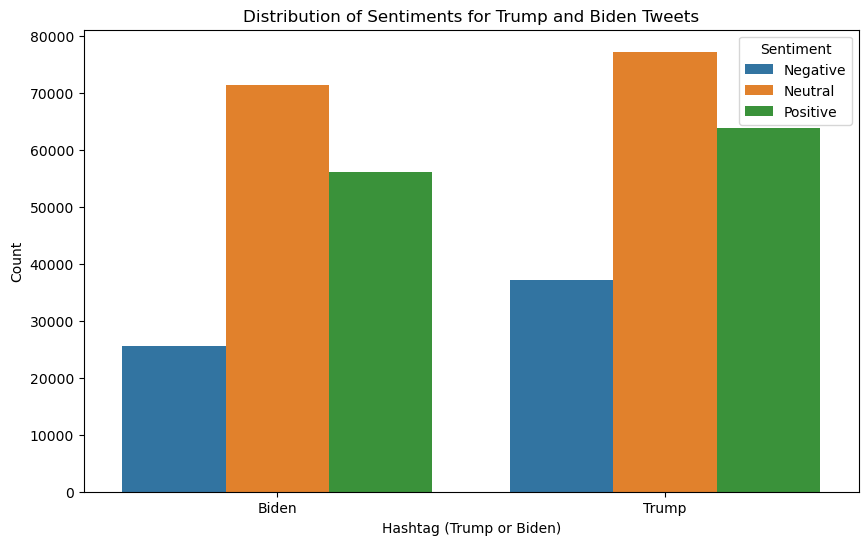

In [146]:
# Group by tweet_hashtag and sentiment to count occurrences
grouped_counts = combined_data.groupby(['tweet_hashtag', 'sentiment']).size().reset_index(name='count')

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_counts, x='tweet_hashtag', y='count', hue='sentiment')
plt.title('Distribution of Sentiments for Trump and Biden Tweets')
plt.xlabel('Hashtag (Trump or Biden)')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

In [147]:
combined_data['state'] = combined_data['state'].str.upper()
electiondata['state'] = electiondata['state'].str.upper()

# Ensuring 'candidatevotes' is numeric
electiondata['candidatevotes'] = pd.to_numeric(electiondata['candidatevotes'], errors='coerce')

# Find the candidate with the most votes per state
# This will give us the rows corresponding to the winner in each state
election_winners = electiondata.loc[electiondata.groupby('state')['candidatevotes'].idxmax()]

# Merging the combined_data with the winners to keep only states where you have a winner
combined_data = pd.merge(combined_data, election_winners, on='state', how='inner')

combined_data.rename(columns={'party_simplified': 'state_vote'}, inplace=True)
combined_data = combined_data.loc[:, ~combined_data.columns.duplicated()]

Classification Report:
               precision    recall  f1-score   support

    DEMOCRAT       0.52      0.43      0.47     21764
  REPUBLICAN       0.51      0.60      0.55     21764

    accuracy                           0.52     43528
   macro avg       0.52      0.52      0.51     43528
weighted avg       0.52      0.52      0.51     43528



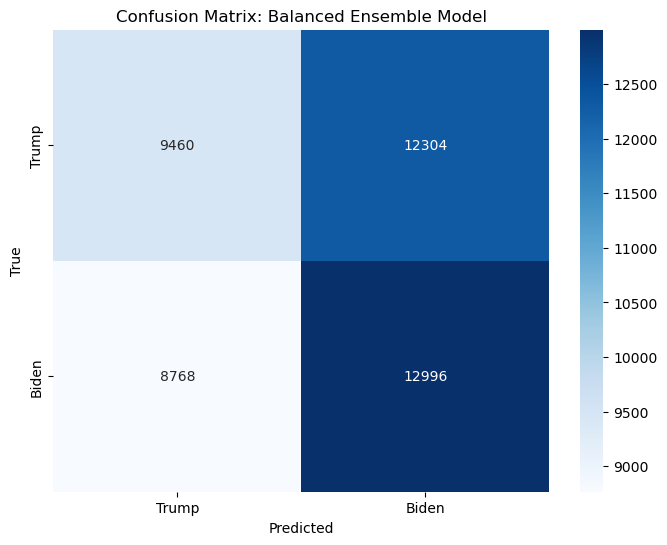

In [148]:
# Step 1: Separate majority and minority classes

biden_data = combined_data[combined_data['state_vote'] == 'DEMOCRAT']

trump_data = combined_data[combined_data['state_vote'] == 'REPUBLICAN']


# Step 2: Undersample the majority class
minority_size = min(len(biden_data), len(trump_data))

# Undersample the larger class to match the minority size
biden_data_downsampled = resample(
    biden_data,
    replace=False,   
    n_samples=minority_size, 
    random_state=42
)

trump_data_downsampled = resample(
    trump_data,
    replace=False,
    n_samples=minority_size,
    random_state=42
)

# Step 3: Combine the balanced datasets
balanced_data = pd.concat([biden_data_downsampled, trump_data_downsampled])

# Step 4: Prepare feature matrix and target vector
X = balanced_data[['sentiment_score', 'hashtag_score', 'likes', 'retweet_count',]]
y = balanced_data['state_vote']

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Define individual models
xgb_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

# Step 7: Create ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model)
    ],
    voting='soft'
)

# Step 8: Fit the model
ensemble_model.fit(X_train, y_train)

# Step 9: Evaluate the model
y_pred = ensemble_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 10: Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Trump', 'Biden'], yticklabels=['Trump', 'Biden'])
plt.title("Confusion Matrix: Balanced Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Now to see if our predictions align with the actual results

In [149]:
# get the mean of the sentiment score for trump and biden in each state
state_sentiment = balanced_data.groupby(['state', 'tweet_hashtag'])['sentiment_score'].mean().unstack()

democrat = state_sentiment['Biden']
republican = state_sentiment['Trump']

# Compute probabilities
state_sentiment['biden_prob'] = democrat / (democrat + republican)
state_sentiment['trump_prob'] = republican / (republican + democrat)

def determine_winner(row):
    if row['biden_prob'] > row['trump_prob']:
        return 'DEMOCRAT'
    else:
        return 'REPUBLICAN'

state_sentiment['predicted_winner'] = state_sentiment.apply(determine_winner, axis=1)

# Print out the result
def get_probability(row):
    if row['predicted_winner'] == 'DEMOCRAT':
        return row['biden_prob']
    else:
        return row['trump_prob']

state_sentiment['probability'] = state_sentiment.apply(get_probability, axis=1)

# Join with state_vote
state_sentiment = state_sentiment.join(balanced_data[['state', 'state_vote']].drop_duplicates().set_index('state'), on='state')

# Printing the number of states predicted correctly
state_sentiment['state_vote'] = state_sentiment['state_vote'].str.upper()
state_sentiment['predicted_winner'] = state_sentiment['predicted_winner'].str.upper()

correct_predictions = state_sentiment[state_sentiment['state_vote'] == state_sentiment['predicted_winner']]
print(f"Number of states predicted correctly: {correct_predictions.shape[0]} / {len(state_sentiment)}")

# Printing out the result
print(state_sentiment[['predicted_winner', 'probability', 'state_vote']])


swing_states = [
    'ARIZONA', 'GEORGIA', 'MICHIGAN', 
    'NEVADA', 'PENNSYLVANIA', 'NORTH CAROLINA', 'WISCONSIN'
]

swing = state_sentiment.loc[swing_states]


# Count how many swing states were correctly predicted
correct_predictions = (swing['predicted_winner'] == swing['state_vote']).sum()
total_swing_states = len(swing)

print(f"Number of swing states predicted correctly: {correct_predictions} out of {total_swing_states}")

# Print the swing states
print(swing[['predicted_winner', 'probability', 'state_vote']])




Number of states predicted correctly: 30 / 51
                     predicted_winner  probability  state_vote
state                                                         
ALABAMA                    REPUBLICAN     0.500449  REPUBLICAN
ALASKA                       DEMOCRAT     0.529670  REPUBLICAN
ARIZONA                      DEMOCRAT     0.506321    DEMOCRAT
ARKANSAS                     DEMOCRAT     0.538117  REPUBLICAN
CALIFORNIA                   DEMOCRAT     0.520791    DEMOCRAT
COLORADO                     DEMOCRAT     0.528246    DEMOCRAT
CONNECTICUT                  DEMOCRAT     0.509132    DEMOCRAT
DELAWARE                     DEMOCRAT     0.521353    DEMOCRAT
DISTRICT OF COLUMBIA         DEMOCRAT     0.511930    DEMOCRAT
FLORIDA                    REPUBLICAN     0.500660  REPUBLICAN
GEORGIA                      DEMOCRAT     0.510276    DEMOCRAT
HAWAII                     REPUBLICAN     0.504496    DEMOCRAT
IDAHO                        DEMOCRAT     0.511731  REPUBLICAN
ILLINOIS 

# Unsupervised learning: election results 1972-2020

### K-means clustering: Batteground states

/var/folders/09/83jk4_t11g1_xbmpbwwcq7sc0000gn/T/ipykernel_22522/1957739659.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['vote_share'] = data['candidatevotes'] / data['totalvotes'] * 100


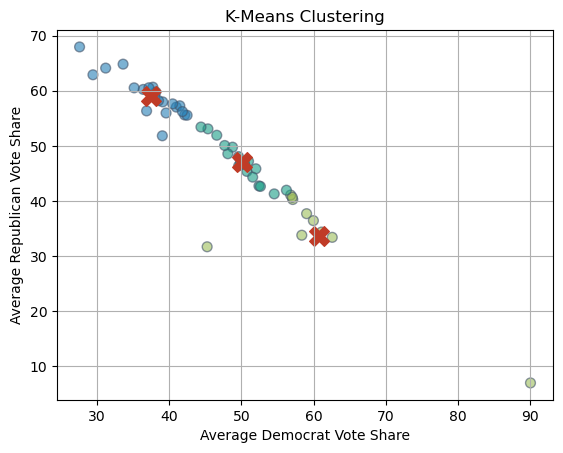

party_simplified   DEMOCRAT  LIBERTARIAN     OTHER  REPUBLICAN
Cluster                                                       
0                 37.472259     1.424060  0.565454   59.057926
1                 50.109860     1.257093  0.395367   46.988106
2                 60.743921     0.991756  0.522767   33.598031


In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

def plot_data(X: np.ndarray, labels: np.ndarray, centroids: np.ndarray = None,
              show_distance: bool = False):
    colors = [
        "#2580B7", # Blue
        "#179E86", # Dark Green
        "#9EBE5B", # Light Green
        "#F59B11", # Yellow
        "#C03B26", # Red
        "#633248", # Brown
        "#44546A", # Gray
    ]
    if show_distance and centroids is not None:
        for centroid in centroids:
            for point in X:
                plt.plot(
                    [centroid[0], point[0]], [centroid[1], point[1]],
                    color=colors[-1], alpha=0.2, linestyle="--",
                    linewidth=0.5
                )
    plt.scatter(
        X[:, 0], X[:, 1], c=[colors[int(label)] for label in labels],
        s=50, edgecolor=colors[-1], alpha=0.6
    )
    if centroids is not None:
        plt.scatter(
            centroids[:, 0], centroids[:, 1], s=200, c=colors[4], marker="X"
        )
    plt.title("K-Means Clustering")
    plt.xlabel("Average Democrat Vote Share")
    plt.ylabel("Average Republican Vote Share")
    plt.grid(True)
    plt.show()

def initialize_centroids(X: np.ndarray, k: int) -> np.ndarray:
    indices = np.random.permutation(X.shape[0])
    centroids = X[indices[:k]]
    return centroids

def assign_clusters(X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(X: np.ndarray, labels: np.ndarray, k: int) -> np.ndarray:
    centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    return centroids

def k_means(X: np.ndarray, k: int, max_iters: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return centroids, labels

# Prepare data for clustering
data = election_results_2000_to_2020[['year', 'state', 'party_simplified', 'candidatevotes', 'totalvotes']]
data['vote_share'] = data['candidatevotes'] / data['totalvotes'] * 100

# Pivot data to calculate average party vote shares per state
vote_shares = data.pivot_table(index=['state'], columns='party_simplified', 
                               values='vote_share', aggfunc='mean', fill_value=0)
X = vote_shares[['DEMOCRAT', 'REPUBLICAN']].to_numpy()

# Apply k-means clustering
np.random.seed(42)
k = 3
centroids, labels = k_means(X, k)

# Plot the clustered data
plot_data(X, labels, centroids)

# Analyze the clusters
vote_shares['Cluster'] = labels
print(vote_shares.groupby('Cluster').mean())